In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [18]:
df = pd.read_excel('heart_disease.xlsx')
df

,age,Age in years
0,Gender,"Gender ; Male - 1, Female -0"
1,cp,Chest pain type
2,trestbps,Resting blood pressure
3,chol,cholesterol measure
4,fbs,(fasting blood sugar > 120 mg/dl) (1 = true; 0...
5,restecg,"ecg observation at resting condition, -- Val..."
6,thalch,maximum heart rate achieved
7,exang,exercise induced angina
8,oldpeak,ST depression induced by exercise relative to ...
9,slope,the slope of the peak exercise ST segment


In [19]:
df.shape

(12, 2)

In [20]:
df.columns.tolist()

['age', 'Age in years']

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           12 non-null     object
 1   Age in years  12 non-null     object
dtypes: object(2)
memory usage: 324.0+ bytes


In [22]:
df.head()

,age,Age in years
0,Gender,"Gender ; Male - 1, Female -0"
1,cp,Chest pain type
2,trestbps,Resting blood pressure
3,chol,cholesterol measure
4,fbs,(fasting blood sugar > 120 mg/dl) (1 = true; 0...


In [23]:
# Check for missing values
df.isnull().sum()

,0
age,0
Age in years,0


In [24]:
df.describe()

,age,Age in years
count,12,12
unique,12,12
top,Gender,"Gender ; Male - 1, Female -0"
freq,1,1


In [29]:
df = pd.read_excel('heart_disease.xlsx', skiprows=12)
df

,num,"target [0=no heart disease; 1,2,3,4 = stages of heart disease ]"


In [30]:
df['num'].value_counts()

,count
num,


In [32]:
df['num'].value_counts(normalize=True)

,proportion
num,


In [37]:
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

In [46]:
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']

In [50]:
print("\nZeros in numerical columns:")
for col in numerical_cols:
    zero_count = (df[col] == 0).sum()
    if zero_count > 0:
        print(f"{col}: {zero_count} zeros")


Zeros in numerical columns:
trestbps: 1 zeros
chol: 172 zeros
oldpeak: 358 zeros


In [51]:
plt.figure(figsize=(15, 12))

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

Text(0, 0.5, 'Count')

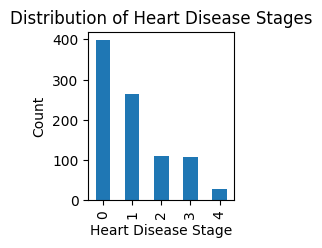

In [54]:
# Distribution of target variable
plt.subplot(2, 3, 1)
df['num'].value_counts().plot(kind='bar')
plt.title('Distribution of Heart Disease Stages')
plt.xlabel('Heart Disease Stage')
plt.ylabel('Count')

Text(0, 0.5, 'Frequency')

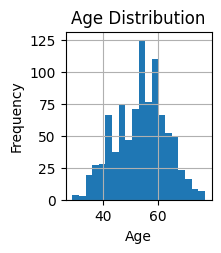

In [55]:
# Age distribution
plt.subplot(2, 3, 2)
df['age'].hist(bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

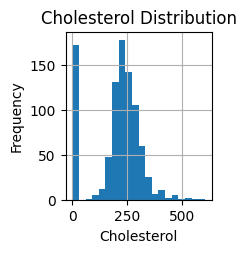

In [56]:
# Cholesterol distribution
plt.subplot(2, 3, 3)
df['chol'].hist(bins=20)
plt.title('Cholesterol Distribution')
plt.xlabel('Cholesterol')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

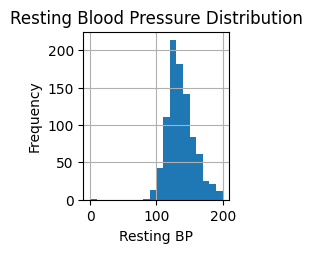

In [58]:
# Resting blood pressure distribution
plt.subplot(2, 3, 4)
df['trestbps'].hist(bins=20)
plt.title('Resting Blood Pressure Distribution')
plt.xlabel('Resting BP')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

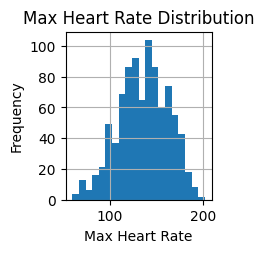

In [60]:
# Maximum heart rate distribution
plt.subplot(2, 3, 5)
df['thalch'].hist(bins=20)
plt.title('Max Heart Rate Distribution')
plt.xlabel('Max Heart Rate')
plt.ylabel('Frequency')

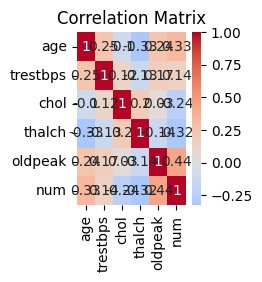

In [69]:
# Correlation matrix
plt.subplot(2, 3, 6)

# Select only numerical columns for correlation
numerical_df = df.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

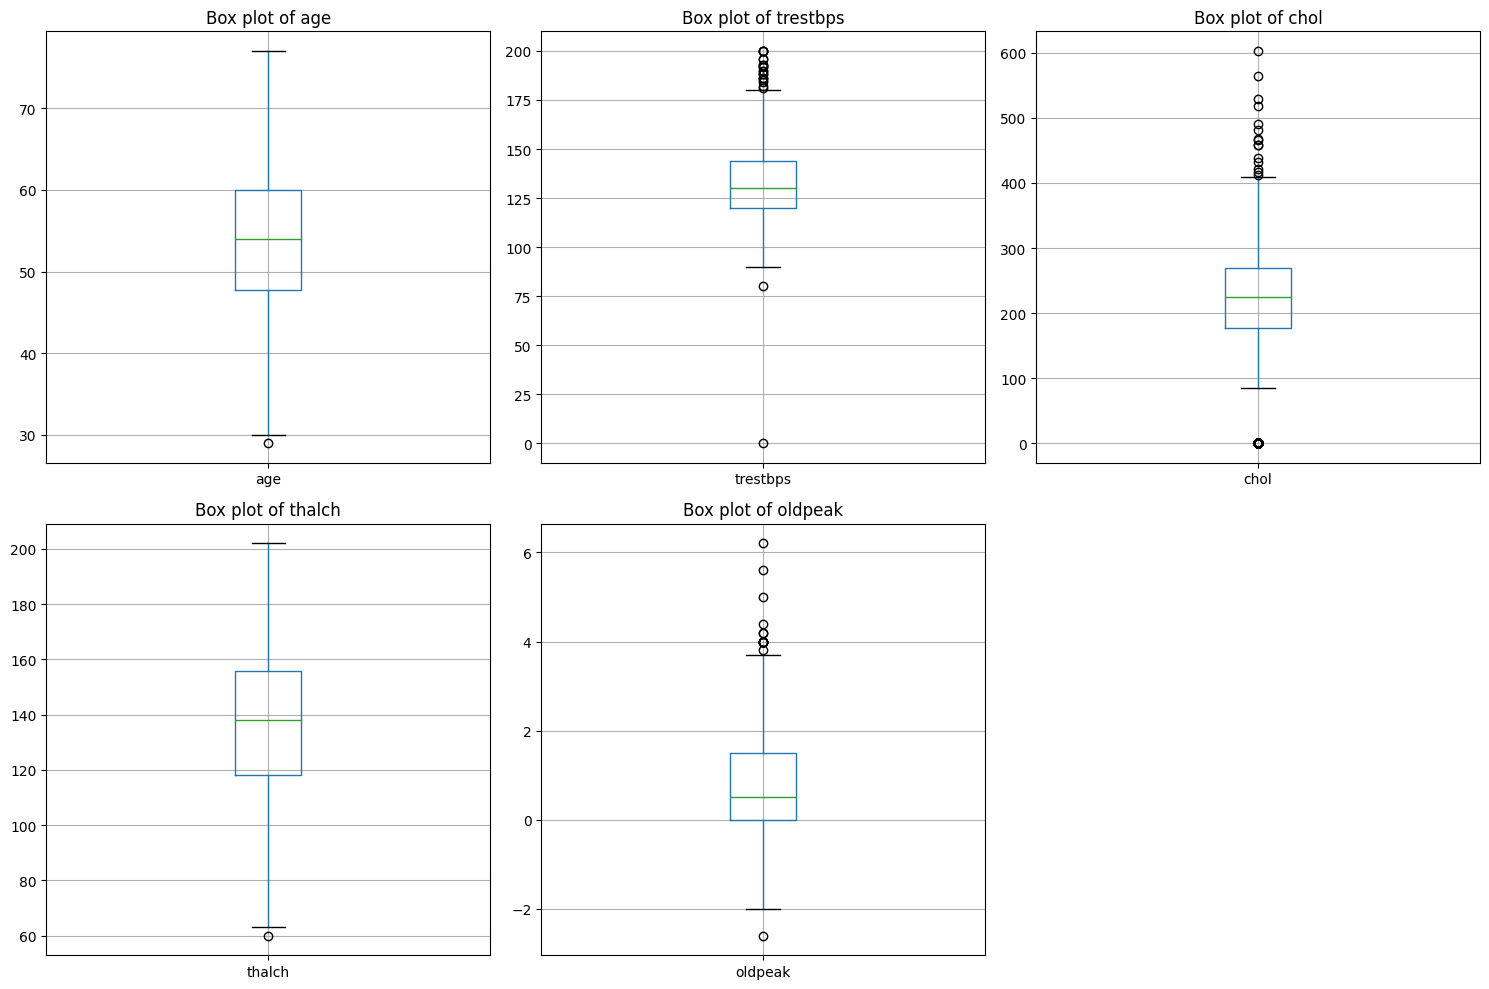

In [63]:
 Box plots for numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    df.boxplot(column=col)
    plt.title(f'Box plot of {col}')

plt.tight_layout()
plt.show()

In [70]:
# Create a copy for preprocessing
df_processed = df.copy()

In [71]:
# Handle missing values - fill with median for numerical columns
for col in numerical_cols:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

In [72]:
# Handle zeros in critical numerical columns (replace with median)
critical_cols = ['trestbps', 'chol', 'thalch']
for col in critical_cols:
    zero_mask = df_processed[col] == 0
    if zero_mask.sum() > 0:
        median_val = df_processed[df_processed[col] != 0][col].median()
        df_processed.loc[zero_mask, col] = median_val
        print(f"Replaced {zero_mask.sum()} zeros in {col} with median value {median_val}")


Replaced 1 zeros in trestbps with median value 130.0
Replaced 172 zeros in chol with median value 240.0


In [73]:
# Encode categorical variables
label_encoders = {}
categorical_cols_to_encode = ['sex', 'cp', 'restecg', 'slope', 'thal']

In [75]:
label_encoders = {}
for col in categorical_cols_to_encode:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Encoded sex: {'0': np.int64(0), '1': np.int64(1)}
Encoded cp: {'asymptomatic': np.int64(0), 'atypical angina': np.int64(1), 'non-anginal': np.int64(2), 'typical angina': np.int64(3)}
Encoded restecg: {'lv hypertrophy': np.int64(0), 'normal': np.int64(1), 'st-t abnormality': np.int64(2)}
Encoded slope: {'downsloping': np.int64(0), 'flat': np.int64(1), 'upsloping': np.int64(2)}
Encoded thal: {'fixed defect': np.int64(0), 'normal': np.int64(1), 'reversable defect': np.int64(2)}


In [87]:
# Convert boolean columns to numerical
bool_cols = ['fbs', 'exang']
for col in bool_cols:
    df_processed[col] = df_processed[col].astype(int)
    print(f"Converted {col} to numerical")

Converted fbs to numerical
Converted exang to numerical


In [88]:
df_processed['heart_disease'] = (df_processed['num'] > 0).astype(int)
print(f"\nBinary target distribution:")
print(df_processed['heart_disease'].value_counts())
print(df_processed['heart_disease'].value_counts(normalize=True))



Binary target distribution:
heart_disease
1    509
0    399
Name: count, dtype: int64
heart_disease
1    0.560573
0    0.439427
Name: proportion, dtype: float64


In [89]:
# Feature selection - drop the original target and keep relevant features
features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
           'thalch', 'exang', 'oldpeak', 'slope', 'thal']


In [90]:
X = df_processed[features]
y = df_processed['heart_disease']

In [92]:
print(f"\nFinal feature set: {X.columns.tolist()}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")


Final feature set: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'thal']
Feature matrix shape: (908, 12)
Target vector shape: (908,)


In [93]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)


In [94]:
X_train.shape
X_test.shape

(182, 12)

In [95]:
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

,proportion
heart_disease,
1,0.56044
0,0.43956


In [96]:
# Scale numerical features (optional for decision trees, but good practice)
scaler = StandardScaler()
numerical_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [97]:
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

In [98]:
# Initial Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(random_state=42)

In [99]:
# Predictions
y_pred = dt_model.predict(X_test_scaled)
y_pred_proba = dt_model.predict_proba(X_test_scaled)[:, 1]

In [100]:
# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [101]:
print("\nInitial Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")


Initial Model Performance:
Accuracy: 0.6703
Precision: 0.7059
Recall: 0.7059
F1-Score: 0.7059
ROC-AUC: 0.6654


In [105]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.62      0.62      0.62        80\n           1       0.71      0.71      0.71       102\n\n    accuracy                           0.67       182\n   macro avg       0.67      0.67      0.67       182\nweighted avg       0.67      0.67      0.67       182\n'

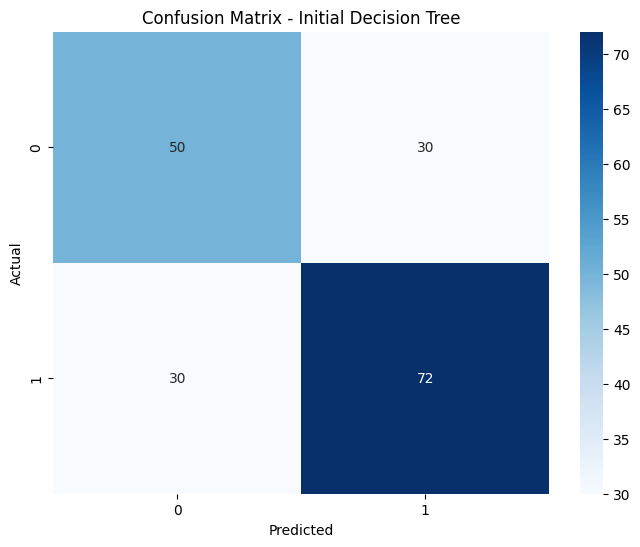

In [106]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Initial Decision Tree')
plt.xlabel('Predicted')

plt.ylabel('Actual')
plt.show()

In [107]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

In [108]:
# Perform grid search
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                          param_grid,
                          cv=5,
                          scoring='f1',
                          n_jobs=-1)

In [109]:
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10, 15, None],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='f1')

In [110]:
# Best parameters and model
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [111]:
print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score:.4f}")

Best parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validation score: 0.8011


In [112]:
# Train model with best parameters
best_dt_model = grid_search.best_estimator_
best_dt_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=5, random_state=42)

In [113]:
# Predictions with tuned model
y_pred_tuned = best_dt_model.predict(X_test_scaled)
y_pred_proba_tuned = best_dt_model.predict_proba(X_test_scaled)[:, 1]

In [114]:
# Evaluation metrics for tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

In [115]:
print("\nTuned Model Performance:")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")
print(f"F1-Score: {f1_tuned:.4f}")
print(f"ROC-AUC: {roc_auc_tuned:.4f}")



Tuned Model Performance:
Accuracy: 0.6978
Precision: 0.7640
Recall: 0.6667
F1-Score: 0.7120
ROC-AUC: 0.7675


In [116]:
classification_report(y_test, y_pred_tuned)

'              precision    recall  f1-score   support\n\n           0       0.63      0.74      0.68        80\n           1       0.76      0.67      0.71       102\n\n    accuracy                           0.70       182\n   macro avg       0.70      0.70      0.70       182\nweighted avg       0.71      0.70      0.70       182\n'

In [117]:
# Compare performance
print("\nPerformance Comparison:")
print(f"{'Metric':<12} {'Initial':<10} {'Tuned':<10} {'Improvement':<12}")
print("-" * 45)
print(f"{'Accuracy':<12} {accuracy:.4f}    {accuracy_tuned:.4f}    {accuracy_tuned-accuracy:+.4f}")
print(f"{'Precision':<12} {precision:.4f}    {precision_tuned:.4f}    {precision_tuned-precision:+.4f}")
print(f"{'Recall':<12} {recall:.4f}    {recall_tuned:.4f}    {recall_tuned-recall:+.4f}")
print(f"{'F1-Score':<12} {f1:.4f}    {f1_tuned:.4f}    {f1_tuned-f1:+.4f}")
print(f"{'ROC-AUC':<12} {roc_auc:.4f}    {roc_auc_tuned:.4f}    {roc_auc_tuned-roc_auc:+.4f}")


Performance Comparison:
Metric       Initial    Tuned      Improvement 
---------------------------------------------
Accuracy     0.6703    0.6978    +0.0275
Precision    0.7059    0.7640    +0.0582
Recall       0.7059    0.6667    -0.0392
F1-Score     0.7059    0.7120    +0.0062
ROC-AUC      0.6654    0.7675    +0.1020


In [118]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_dt_model.feature_importances_
}).sort_values('importance', ascending=False)

In [120]:
print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
     feature  importance
2         cp    0.480919
9    oldpeak    0.125256
7     thalch    0.066197
8      exang    0.061741
4       chol    0.053851
5        fbs    0.053639
1        sex    0.042319
11      thal    0.038178
3   trestbps    0.028598
0        age    0.027562
10     slope    0.021739
6    restecg    0.000000


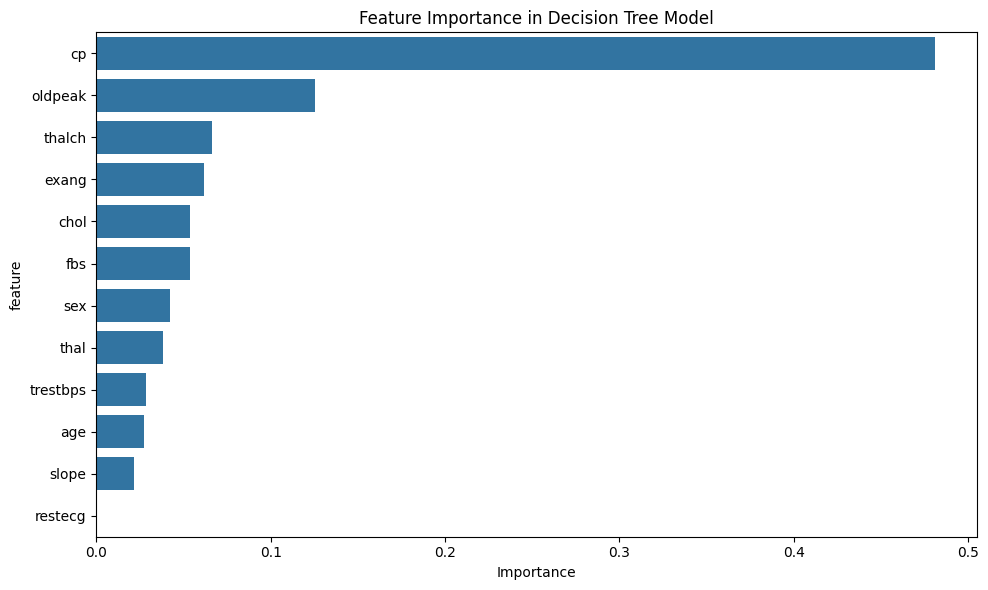

In [121]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance in Decision Tree Model')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

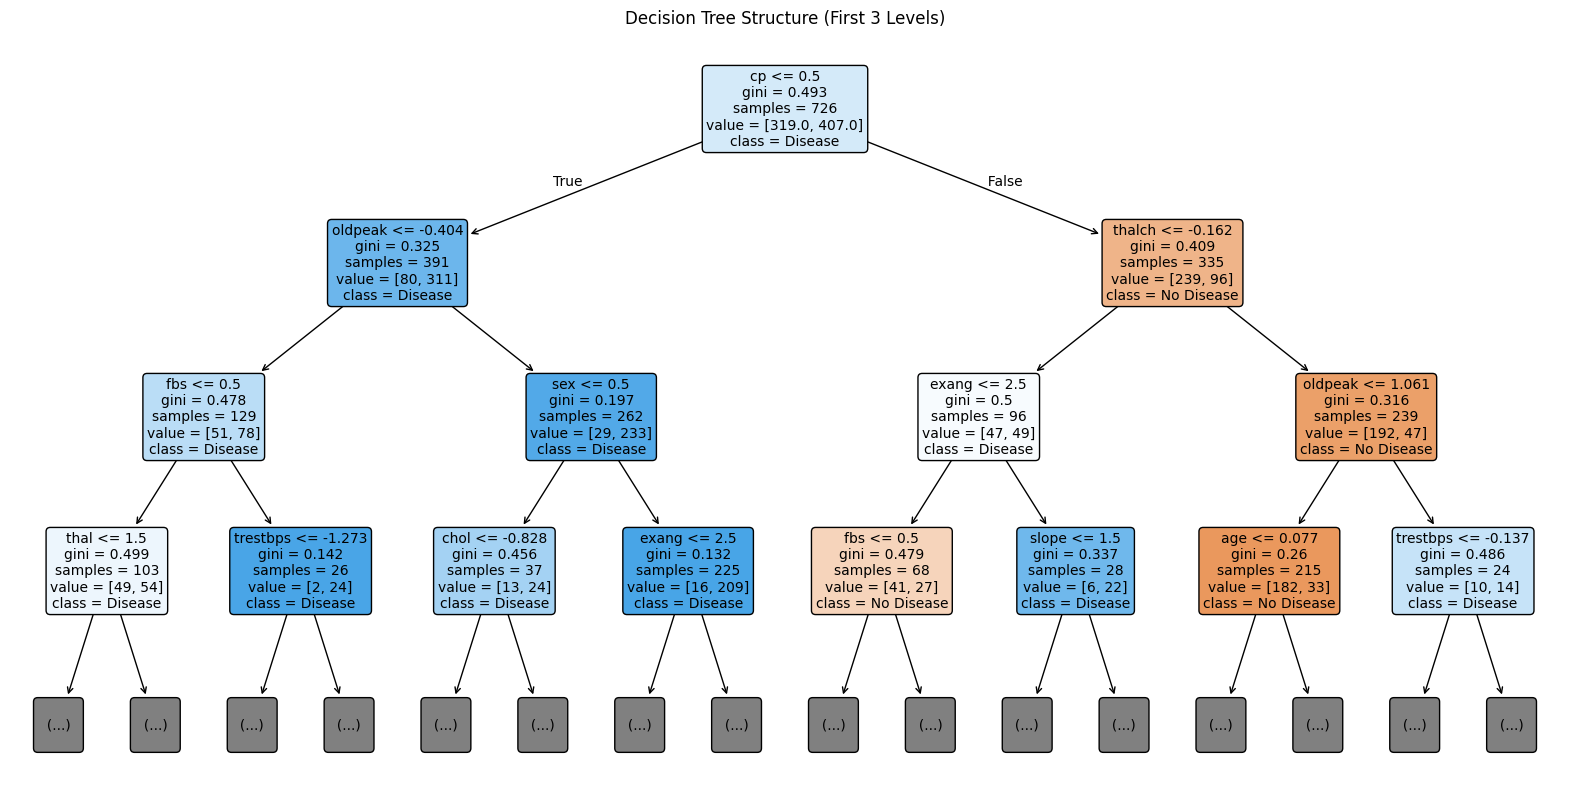

In [122]:
# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_dt_model,
          feature_names=X.columns,
          class_names=['No Disease', 'Disease'],
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3)  # Limit depth for readability
plt.title('Decision Tree Structure (First 3 Levels)')
plt.show()

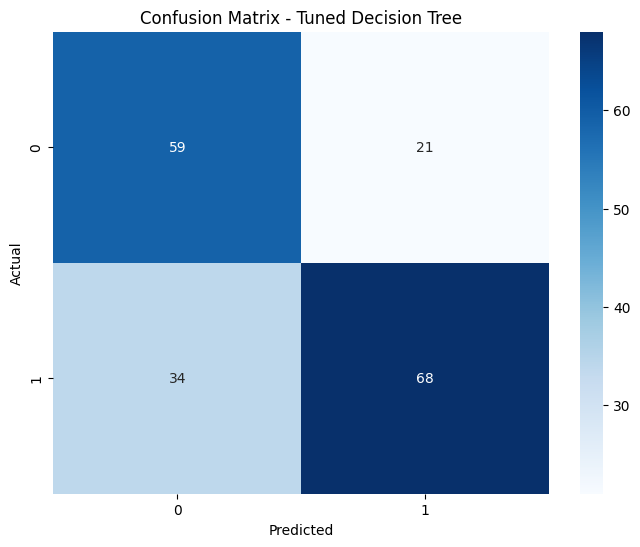

In [123]:
# Confusion matrix for tuned model
plt.figure(figsize=(8, 6))
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Tuned Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [124]:
# Analyze predictions vs actual by age groups
df_test = X_test.copy()
df_test['actual'] = y_test.values
df_test['predicted'] = y_pred_tuned
df_test['age_group'] = pd.cut(df_test['age'], bins=[0, 40, 50, 60, 100],
                             labels=['<40', '40-50', '50-60', '60+'])

In [126]:
age_group_performance = df_test.groupby('age_group').agg({
    'actual': 'mean',
    'predicted': 'mean',
    'age': 'count'
}).rename(columns={'age': 'count'})

In [129]:
# Summary of key findings
print("\n=== SUMMARY ===")
print(f"Dataset: {df.shape[0]} samples, {df.shape[1]} features")
print(f"Target variable: Heart disease (binary classification)")
print(f"Best model performance:")
print(f"  - Accuracy: {accuracy_tuned:.4f}")
print(f"  - F1-Score: {f1_tuned:.4f}")
print(f"  - ROC-AUC: {roc_auc_tuned:.4f}")
print(f"Most important features: {feature_importance['feature'].head(3).tolist()}")
print(f"Optimal tree depth: {best_params.get('max_depth', 'Unlimited')}")


=== SUMMARY ===
Dataset: 908 samples, 13 features
Target variable: Heart disease (binary classification)
Best model performance:
  - Accuracy: 0.6978
  - F1-Score: 0.7120
  - ROC-AUC: 0.7675
Most important features: ['cp', 'oldpeak', 'thalch']
Optimal tree depth: 5


# **Interview Questions Answers**

**N1: What are some common hyperparameters of decision tree models, and how do they affect the model's performance?"**

Common Decision Tree Hyperparameters:

- max_depth: Maximum depth of the tree
  * Too shallow: Underfitting, poor performance
  * Too deep: Overfitting, memorizes training data

- min_samples_split: Minimum samples required to split a node
  * Higher values: Simpler trees, prevent overfitting
  * Lower values: More complex trees, risk of overfitting

- min_samples_leaf: Minimum samples required at a leaf node
  * Higher values: Smoother predictions, prevent overfitting
  * Lower values: More detailed splits, risk of overfitting

- criterion: Function to measure split quality ('gini' or 'entropy')
  * Gini: Computationally faster, similar results to entropy
  * Entropy: More computationally intensive, theoretically purer splits

- max_features: Number of features to consider for best split
  * Controls feature randomness, helps with generalization

- random_state: Seed for reproducibility

**N2: What is the difference between Label encoding and One-hot encoding?**

Label Encoding vs One-Hot Encoding:

Label Encoding:
- Converts categories to numerical values (0, 1, 2, ...)
- Creates ordinal relationship where none may exist
- Can mislead algorithms into thinking categories have order
- Uses less memory and computational resources
- Example: ['red', 'blue', 'green'] → [0, 1, 2]

One-Hot Encoding:
- Creates binary columns for each category
- No implied ordinal relationship
- Prevents algorithms from assuming order
- Can cause curse of dimensionality with many categories
- Example: ['red', 'blue', 'green'] →
  red: [1, 0, 0], blue: [0, 1, 0], green: [0, 0, 1]

In our implementation, we used Label Encoding for categorical variables
because decision trees can handle the numerical representation well, and
it's more memory-efficient for features with multiple categories.